In [58]:
from scipy.stats import distributions as iid
import scipy.stats
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.regression.linear_model import OLS
from scipy.optimize import minimize 

In [234]:
# define dgp
def dgp(N, beta, pi):
    
    # get appropriate dimensions
    l = pi.shape[0]
    
    # generate disturbance terms and random Z
    #u = iid.norm().rvs(size=(N,1)) # why do you do this instead of just N, it seems like it makes it (NXN) instead of (NX1)
    #v = iid.norm().rvs(size = (N,1))
    u = iid.norm().rvs(size = (N,1))
    v = iid.norm().rvs(size = (N,1))
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    X =  X = Z@pi.reshape(-1,1) + v
    y = X*beta + u
    
    return y,X,Z

In [178]:
# write chernozhukov-hansen function
def chern_hansen(y,X,Z,b_0):
    rhs = y-b_0*X
    
    #gamma = np.linalg.solve(Z.T@Z,Z.T@rhs)
    #e = rhs - Z*gamma
    
    model = OLS(rhs, Z)
    results = model.fit()
    
    A = np.identity(len(results.params))
    fresults = results.f_test(A)
    fval = fresults.fvalue
    pval = fresults.pvalue
    
    #return pval
    
    return -pval # negative pval to minimize 

y,X,Z = dgp(10000, 1, np.array([1]))
test = chern_hansen(y,X,Z,1)
print(test)

-0.04139965172674935


In [191]:
### find the value of b_0 that maximizes p-values (we do not want to reject that the coefficients are 0)
N = 1000 
beta_true = 1
pi = np.array([1])
y_,X_,Z_ = dgp(N, beta_true, pi)

beta_hat = minimize(lambda b: chern_hansen(y_,X_,Z_,b), x0=1, method = 'Nelder-Mead').x 
# suuuper sensitive to starting values so not sure if this really checks out
print(beta_hat)

[0.99223022]


In [184]:
def chern_hansen_iter(N, beta_true, pi, x0=0):
    y,X,Z = dgp(N, beta_true, pi)
    beta_hat = minimize(lambda b: chern_hansen(y,X,Z,b), x0=x0, method = 'Nelder-Mead').x
    return(beta_hat)

In [187]:
# describe bias and precision
# bias
bias = beta_true - beta_hat

# precision
# perform many estimations and see the variance
N = 1000 
beta_true = 1
pi = np.array([1])
betas = [chern_hansen_iter(N, beta_true, pi) for i in range(100)] 
betas = np.asarray(betas)
print(betas.mean())
print(betas.var())

1.000019843750001
0.0007127027544189465


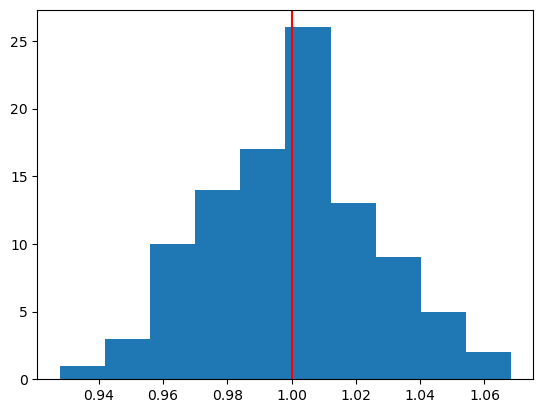

In [188]:
# plot the estimates to visualize bias and precision
fig, ax = plt.subplots(1, 1) # initialize 3 subplots
ax.hist(betas)
ax.axvline(x=beta_true, color='r', label='True beta')

In [213]:
# part 3: the 95 CI on beta  --- this is very shaky not gonna lie
crit_val = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=N-1)

# get gamma and error
rhs = y_-beta_hat*X_
gamma = np.linalg.solve(Z_.T@Z_,Z_.T@rhs)
e = rhs - Z_*gamma
s2 = e.T@e
se = np.linalg.inv(Z.T@Z)*s2

# confidence interval 
ci_lower = beta_hat - crit_val*se
ci_upper = beta_hat + crit_val*se

print(beta_hat)
print(ci_lower)
print(ci_upper)

# clearly wrong!!!!!!!!!!! :)

[0.99223022]
[[-2.773037]]
[[4.75749745]]


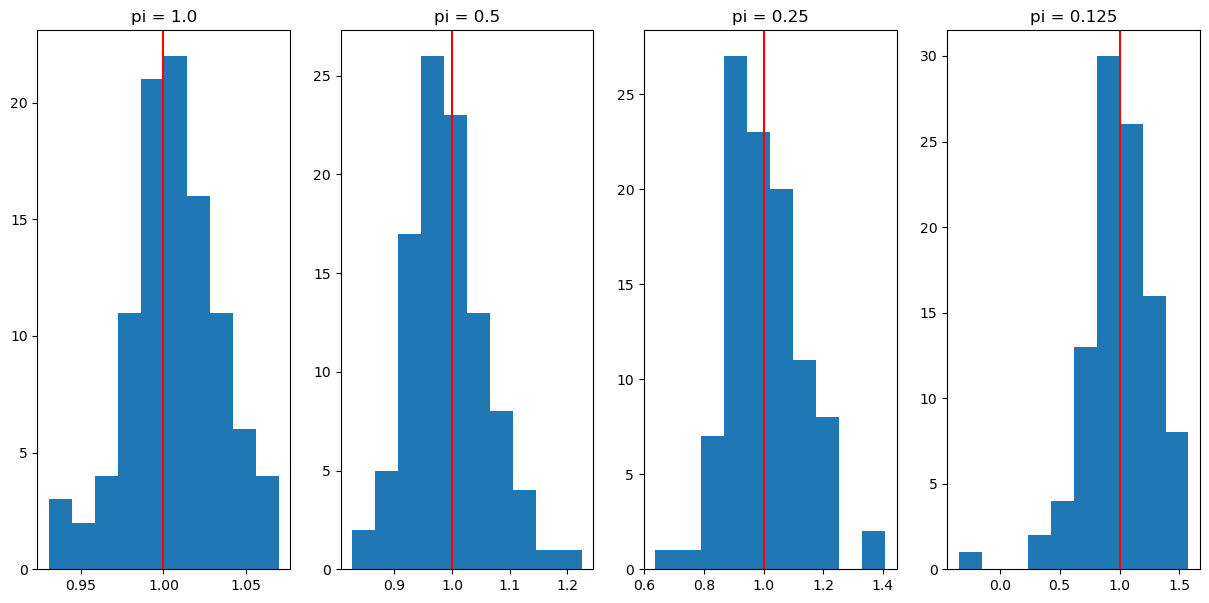

In [231]:
# part 4: not entirely sure what he means by this to be honest 
# so heres a monte carlo simulation with different values of pi that all look pretty similar 
# is that supposed to be the point??? that we can have weak instruments and be ok??
counter = 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize subplots

N = 1000 
beta_true = 1
pi = np.array([1, 0.5, 0.25, 0.125])

for p in pi:
    betas = [chern_hansen_iter(N, beta_true, np.asarray(p).reshape(-1,1)) for i in range(100)]
    betas = np.asarray(betas)
    ax[counter].hist(betas)
    ax[counter].set_title(f"pi = {p}")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

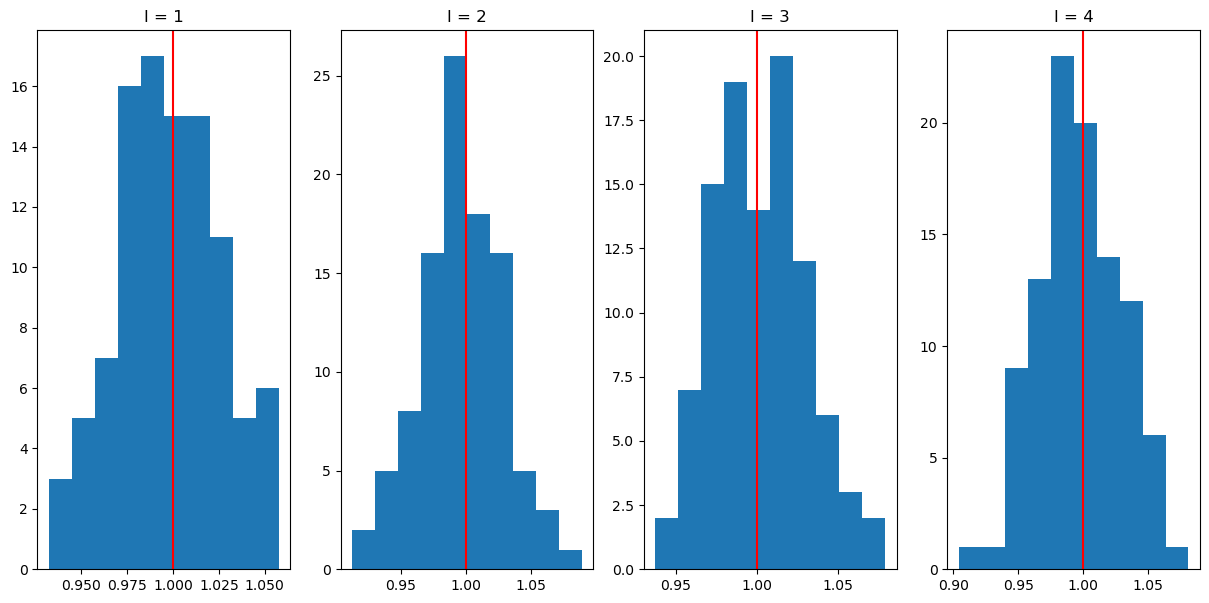

In [242]:
# part 5: not entirely sure what he means by this again to be honest 
# so heres a monte carlo simulation with increasingly uninformative instruments that all look pretty similar 

counter = 0
fig, ax = plt.subplots(1, 4, figsize=(15,7))

for l in range(len(pi)):
    pi_set = pi[0:i+1]
    betas = [chern_hansen_iter(N, beta_true, pi_set) for i in range(100)]
    betas = np.asarray(betas)
    ax[counter].hist(betas)
    ax[counter].set_title(f"l = {l+1}")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1